<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  Book Reviews Capstone Project: Data Cleaning and EDA


*Delphine Defforey*

___

<font color=navy>
    In this notebook, I merge together the datasets from the previous three notebooks, filter reviews so that they are only in English (a requirement for using VaderSentiment later on) and perform some preliminary visualisation of my text data. Comments are interspersed throughout the notebook as needed to highlight assumptions, potential risks/limitations and insights from figures. 
    </font>

### Imports and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm_notebook
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import textacy
import spacy
from langdetect import detect 
from langdetect import DetectorFactory  

In [2]:
nltk.download('stopwords')
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddefforey1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Configs

In [3]:
lib_thing_path = '/Users/ddefforey1/work/capstone_datasets/lib_thing_dataset_clean.csv'
cleaner_book_info_path = '/Users/ddefforey1/work/capstone_datasets/cleaner_book_info.csv'
missing_ibns_path = '/Users/ddefforey1/work/capstone_datasets/missing_isbns.csv'
clean_book_genres_path = '/Users/ddefforey1/work/capstone_datasets/clean_book_genres.csv'
final_clean_dataset_path = '/Users/ddefforey1/work/capstone_datasets/final_clean_data.csv'

fantasy_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/fantasy_reviews1.png'
fiction_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/fiction_reviews1.png'
nonfiction_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/nonfiction_reviews1.png'
scifi_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/scifi_reviews1.png'
mystery_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/mystery_reviews1.png'
thriller_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/thriller_reviews1.png'
romance_wordcloud_path = '/Users/ddefforey1/work/capstone_datasets/wordclouds/romance_reviews1.png'

### Merging the Datasets

In [4]:
# here, I'm reading the data as object data types as I did with the previous datasets
# this will allow me to merge them on the id column without any data type issues
lib_thing = pd.read_csv(lib_thing_path,  dtype=object)

In [5]:
lib_thing.head()

,reviews,n_helpful,stars,time,user,id
0,This a great book for young readers to be intr...,0,5.0,"Nov 7, 2007",van_stef,3206242
1,Help Wanted: Tales of On The Job Terror from E...,0,5.0,"Apr 7, 2012",dwatson2,12198649
2,"Magoon, K. (2012). Fire in the streets. New Yo...",0,NaN,"Nov 15, 2012",edspicer,12533765
3,"Well, I definitely liked this book better than...",0,4.0,"Mar 29, 2013",amdrane2,12981302
4,It's a nice science-fiction thriller with some...,0,3.0,"Apr 11, 2010",Lila_Gustavus,5231009


In [6]:
# removing the stars column for now since it contains NaNs
ratings = lib_thing.pop('stars')

In [7]:
# changing the n_helpful column data type to integer rather than object
lib_thing['n_helpful'] = lib_thing.n_helpful.astype(int)

In [8]:
# checking that the data types are correct
lib_thing.dtypes

reviews      object
n_helpful     int64
time         object
user         object
id           object
dtype: object

In [9]:
# looking at missing values in the dataframe
lib_thing.isnull().sum()

reviews      226
n_helpful      0
time           0
user           1
id             0
dtype: int64

In [10]:
# filling missing user name with 'unknown'
lib_thing['user'] = lib_thing.user.fillna('unknown')

In [11]:
# dropping entries with missing text reviews
lib_thing.dropna(inplace=True)

In [12]:
lib_thing.shape

(1548227, 5)

In [13]:
# reading in the file with book titles, author names and ISBNs associated with books IDs
# here it is important to set the data type to object to avoid the leading zeros in the isbn column from being dropped
book_info = pd.read_csv(cleaner_book_info_path, dtype=object)

In [14]:
book_info.head()

,id,book_title,author,isbn
0,4979986,The Hunger Games,Suzanne Collins,0439023483
1,8384326,Twilight (2005),Stephenie Meyer,0316015849
2,1541442,The Girl with the Dragon Tattoo (2005),Stieg Larsson,0307454541
3,393681,The Book Thief (2007),Markus Zusak,0375842209
4,8662515,Catching Fire,Suzanne Collins,0439023491


In [15]:
# merging the lib_thing and book_info dataframes on the id column
book_info_reviews = pd.merge(lib_thing, book_info, on='id', how='outer')

In [16]:
# verifying the shape of the new dataframe
book_info_reviews.shape

(1548227, 8)

In [17]:
# checking the number of missing entries
book_info_reviews.isnull().sum()

reviews             0
n_helpful           0
time                0
user                0
id                  0
book_title    1113802
author        1113802
isbn          1221229
dtype: int64

In [18]:
# dropping all the entries with NaN values
# these correspond to book for which I don't have book titles, author names or ISBNs
book_info_reviews.dropna(inplace=True)

In [19]:
# checking that the number of rows is the same as that of the book_info dataframe
book_info_reviews.shape

(326998, 8)

In [20]:
book_info_reviews.head()

,reviews,n_helpful,time,user,id,book_title,author,isbn
0,This a great book for young readers to be intr...,0,"Nov 7, 2007",van_stef,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307
1,Not as great a literary work as Tolkien's famo...,1,"Aug 10, 2007",EvilPlatypus,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307
2,Fantastic!,0,"Aug 23, 2011",elviomedeiros,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307
3,Bilbo Baggins becomes an accidental hero in th...,0,"Dec 3, 2012",ewyatt,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307
4,I found the Hobbit when I was in the 5th grade...,0,"May 11, 2007",Nikkles,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307


In [21]:
# reading in the dataset with book genres
# again, the data type needs to be set to object so the ISBNs are read correctly
book_genres = pd.read_csv(clean_book_genres_path, dtype=object)

In [22]:
book_genres.shape

(3265, 6)

In [23]:
# removing the goodreads_shelves column, which is redundant
shelf_info = book_genres.pop('goodreads_shelves')

In [24]:
book_genres.head()

,id,goodreads_id,isbn,goodreads_book_titles,book_genres
0,4979986,2767052,0439023483,"The Hunger Games (The Hunger Games, #1)",['science-fiction']
1,8384326,41865,0316015849,"Twilight (Twilight, #1)",['fantasy']
2,1541442,5291539,0307454541,"The Girl with the Dragon Tattoo (Millennium, #1)","['mystery', 'fiction', 'thriller']"
3,393681,39395800,0375842209,The Book Thief,"['non-fiction', 'fiction']"
4,8662515,6148028,0439023491,"Catching Fire (The Hunger Games, #2)",['science-fiction']


In [25]:
# cleaning up the book_genres column
# because the entries were read as an object data type, these are strings rather than lists
book_genres['book_genres'] = book_genres.book_genres.str.replace('[','').str.replace(']','').str.replace("'", "").str.replace(' ', '')

In [26]:
# splitting up each book genre into separate columns
categories = book_genres.book_genres.str.split(',', expand=True)
categories.columns = ['genre_1', 'genre_2', 'genre_3']

In [27]:
categories.head()

,genre_1,genre_2,genre_3
0,science-fiction,None,None
1,fantasy,None,None
2,mystery,fiction,thriller
3,non-fiction,fiction,None
4,science-fiction,None,None


In [28]:
# for now I will work with the main genre of each book (genre_1)
# note that this may lead to an oversimplification of book genres in some instances
book_genres['book_genres'] = categories.genre_1

In [29]:
book_genres.head()

,id,goodreads_id,isbn,goodreads_book_titles,book_genres
0,4979986,2767052,0439023483,"The Hunger Games (The Hunger Games, #1)",science-fiction
1,8384326,41865,0316015849,"Twilight (Twilight, #1)",fantasy
2,1541442,5291539,0307454541,"The Girl with the Dragon Tattoo (Millennium, #1)",mystery
3,393681,39395800,0375842209,The Book Thief,non-fiction
4,8662515,6148028,0439023491,"Catching Fire (The Hunger Games, #2)",science-fiction


In [30]:
# merging the book genres dataframe with the main dataframe
book_info_reviews_genres = pd.merge(book_info_reviews, book_genres, on='id', how='outer')

In [31]:
book_info_reviews_genres.shape

(326998, 12)

In [32]:
book_info_reviews_genres.isnull().sum()

reviews                      0
n_helpful                    0
time                         0
user                         0
id                           0
book_title                   0
author                       0
isbn_x                       0
goodreads_id             31196
isbn_y                   31196
goodreads_book_titles    31196
book_genres              31196
dtype: int64

In [33]:
book_info_reviews_genres.dropna(inplace=True)

In [34]:
book_info_reviews_genres.shape

(295802, 12)

In [35]:
book_info_reviews_genres.head()

,reviews,n_helpful,time,user,id,book_title,author,isbn_x,goodreads_id,isbn_y,goodreads_book_titles,book_genres
0,This a great book for young readers to be intr...,0,"Nov 7, 2007",van_stef,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,5907,0618260307,The Hobbit or There and Back Again,fantasy
1,Not as great a literary work as Tolkien's famo...,1,"Aug 10, 2007",EvilPlatypus,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,5907,0618260307,The Hobbit or There and Back Again,fantasy
2,Fantastic!,0,"Aug 23, 2011",elviomedeiros,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,5907,0618260307,The Hobbit or There and Back Again,fantasy
3,Bilbo Baggins becomes an accidental hero in th...,0,"Dec 3, 2012",ewyatt,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,5907,0618260307,The Hobbit or There and Back Again,fantasy
4,I found the Hobbit when I was in the 5th grade...,0,"May 11, 2007",Nikkles,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,5907,0618260307,The Hobbit or There and Back Again,fantasy


In [36]:
# looking at a sample of a book review
book_info_reviews_genres.reviews[10]

"I finally read The Hobbit. Not sure why it took me so long, but I'm glad I did. As soon as I opened the book (well, clicked on it on my Kindle), I thought, this was meant to be read aloud. It'd definitely written for a younger audience than the Lord of the Rings, although some pretty nasty things happen--it's particularly dangerous to be a pony associated with this group. The dwarves' motivation for their quest isn't as noble, but Bilbo is endearing and honest and grows as the story progresses. I couldn't believe the book was originally published in 1937! "

In [37]:
# removing the columns I no longer need
book_info_reviews_genres = book_info_reviews_genres[['reviews', 'n_helpful', 'time', 'user', 'id', 'book_title', 'author', 'isbn_x', 'book_genres']]

In [38]:
# books with no assigned genres
book_info_reviews_genres.id[book_info_reviews_genres.book_genres == ''].unique()

array(['6504869', '10765429', '2451293', '5726341', '3241380', '2982564',
       '3248292', '9020710', '6069885', '4113166'], dtype=object)

In [39]:
index_drop = book_info_reviews_genres[book_info_reviews_genres.book_genres == ''].index

In [40]:
# removing the books without assigned booked genres
book_info_reviews_genres = book_info_reviews_genres.drop(index_drop).reset_index(drop=True)

In [41]:
print("There are {} reviews and {} features in this dataset. \n".format(book_info_reviews_genres.shape[0],book_info_reviews_genres.shape[1]))
print("There are {} book genres in this dataset such as {}... \n".format(len(book_info_reviews_genres.book_genres.unique()),
                                                                           ", ".join(book_info_reviews_genres.book_genres.unique()[0:5])))

There are 295162 reviews and 9 features in this dataset. 

There are 7 book genres in this dataset such as fantasy, fiction, science-fiction, mystery, non-fiction... 



### Identifying and Removing Reviews in Languages other than English

<font color=navy>
    Given that VaderSentiment does not work with non-English text, book reviews in other languages will have to be identified and removed. To do this, I use the Python interface for Google's language-detection library (langdetect). The language detection algorithm is non-deterministic, which means that if one tries to run it on text that is either too short or too ambiguous, one might get different results everytime the algorithm is run. To enforce consistent results, I am specifying a seed of 0:
    </font>

In [42]:
DetectorFactory.seed = 0

In [43]:
def lang_detect(text):
    """function for error management due to error when no text is contained in the comment"""
    try:
        return detect(text)
    except:
        return 'na'

In [44]:
# verifying that the function correctly assigns languages and handles NaN values
print(lang_detect(np.nan))
print(lang_detect('hello there, nice to see you'))
print(lang_detect('salut comment vas-tu'))

na
en
fr


In [45]:
book_info_reviews_genres['language'] = book_info_reviews_genres.reviews.apply(lambda x: lang_detect(x))

In [46]:
book_info_reviews_genres.head()

,reviews,n_helpful,time,user,id,book_title,author,isbn_x,book_genres,language
0,This a great book for young readers to be intr...,0,"Nov 7, 2007",van_stef,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,en
1,Not as great a literary work as Tolkien's famo...,1,"Aug 10, 2007",EvilPlatypus,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,en
2,Fantastic!,0,"Aug 23, 2011",elviomedeiros,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,it
3,Bilbo Baggins becomes an accidental hero in th...,0,"Dec 3, 2012",ewyatt,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,en
4,I found the Hobbit when I was in the 5th grade...,0,"May 11, 2007",Nikkles,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,en


In [47]:
# checking which reviews were labelled as other than English
book_info_reviews_genres[book_info_reviews_genres.language != 'en'].head()

,reviews,n_helpful,time,user,id,book_title,author,isbn_x,book_genres,language
2,Fantastic!,0,"Aug 23, 2011",elviomedeiros,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,it
18,"De prequel van Lord of the Rings, over de reis...",0,"Sep 3, 2010",jaelanna,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,nl
24,http://verniciousknids.blogspot.com/2006/09/bu...,0,"Oct 1, 2006",verniciousknids,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,na
28,True genius.,1,"Jul 27, 2008",GMWestermeyer,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,lt
55,Die Geschichte um den Hobbit Bilbo Beutlin geh...,0,"Sep 21, 2010",Lilya05,3206242,The Hobbit (1937),J. R. R. Tolkien,0618260307,fantasy,de


In [48]:
book_info_reviews_genres[book_info_reviews_genres.language != 'en'].shape

(22563, 10)

In [49]:
index_drop2 = book_info_reviews_genres[book_info_reviews_genres.language != 'en'].index

In [50]:
# removing reviews that are not in English
book_info_reviews_genres = book_info_reviews_genres.drop(index_drop2).reset_index(drop=True)

<font color=navy>
    A potential limitation of this step is that the language of short reviews (1-2 words) cannot be conclusively identified, and therefore some may have been accidentally labeled as being in a language other than English when it fact they were not (e.g. "Fantastic!", "True genius!"). Given the large number of non-English reviews identified, I chose to drop them all and take the risk to lose some English reviews. I found this risk to be acceptable given that such short reviews would likely not play a central role in my topic model.
    </font>

In [51]:
# remaining number of reviews following language filtering
book_info_reviews_genres.shape

(272599, 10)

In [52]:
# saving the final version of the dataset that will be used in my LDA model
book_info_reviews_genres.to_csv(final_clean_dataset_path, index=False)

In [4]:
book_info = pd.read_csv(final_clean_dataset_path,  dtype=object)

In [ ]:
book_info.groupby('book_genres').sum()

### Visualising the Data

<font color=navy>
    Here, I use three approaches to visualise my data. First, I use a bar chart to illustrate the number of reviews for each book genre. Then, I use individual wordclouds for each book genre to get an overview of words commonly found in book reviews. Then, I generate bar plots to visualise counts for individual words following cleaning, tokenisation and lemmatisation.
    </font>

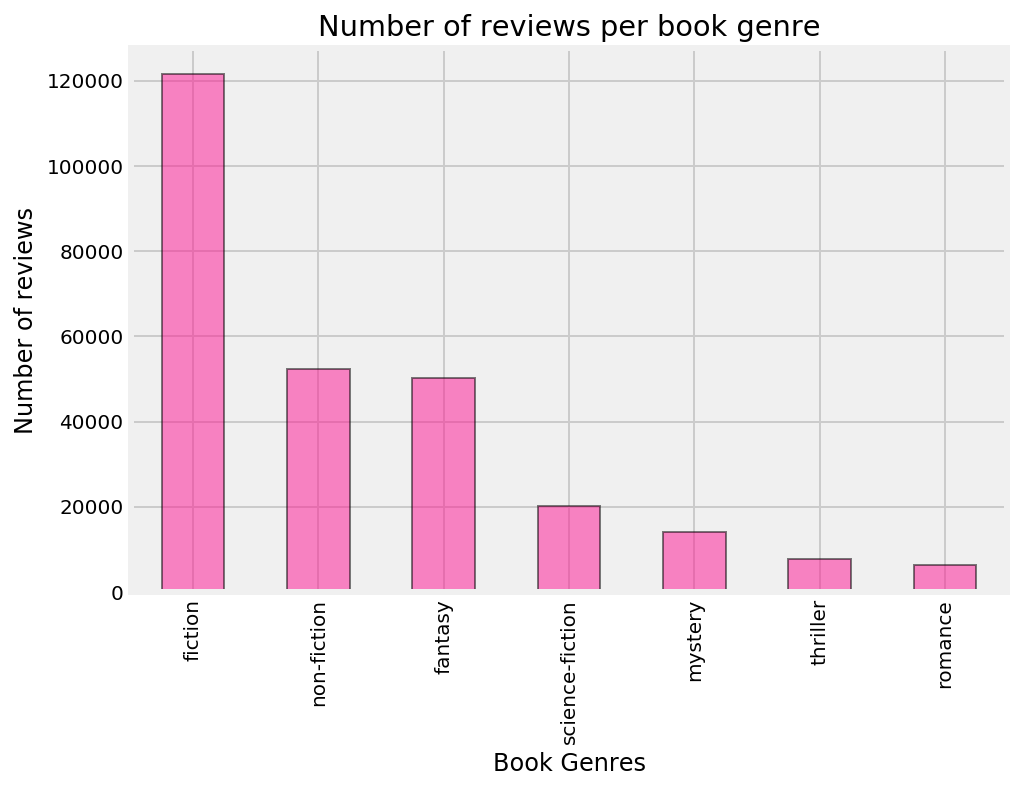

In [53]:
# plotting the number of reviews for each book genre 
ax = book_info_reviews_genres.book_genres.value_counts().plot(kind='bar', figsize=(7,5), edgecolor='black', lw=1, alpha = 0.5, color='deeppink')
ax.set_xlabel('Book Genres')
ax.set_ylabel('Number of reviews')
_ = ax.set_title('Number of reviews per book genre')

<font color=navy>
    The majority of book reviews in this dataset are reviews of fiction books (general fiction, fantasy, science-fiction, mystery, thriller and romance), which means that non-fiction book reviews will be underrepresented in my topic model. This may have an impact on the performance of my LDA model.
    </font>

In [54]:
def generate_wordcloud(book_genre, path):
    """
    Removes stopwords then creates a wordcloud from book reviews. Saves a copy of the wordcloud as a png file 
    at the location specified.
    """
    stopwords = set(STOPWORDS)
    stopwords.update(['one', 'much', 'still', 'novel', 'book', 'even', 'though', 'really', 'now', 'come', 
                      'work', 'thing', 'way', 'rather', 'made', 'will', 'bit', 'left', 'make', 'read',
                      'think', 'book', 'find', 'know', 'lot', 'found', 'another', 'page', 'first', 'part', 'take', 
                      'thing', 'many', 'give', 'make', 'quite', 'although', 'see', 'yet'])
    text = " ".join(review for review in book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == book_genre])

    wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=800, height=400).generate(text)
    image = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis('off')
    
    wordcloud.to_file(path)
    
    return image

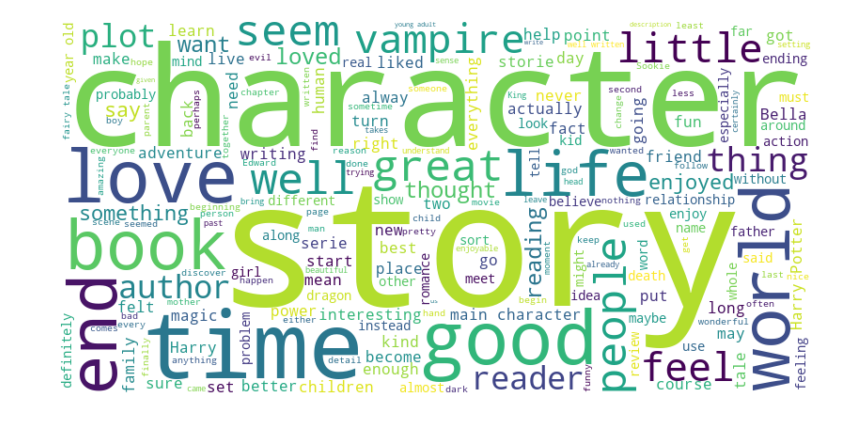

In [55]:
# wordcloud for fantasy book reviews
_ = generate_wordcloud('fantasy', fantasy_wordcloud_path)

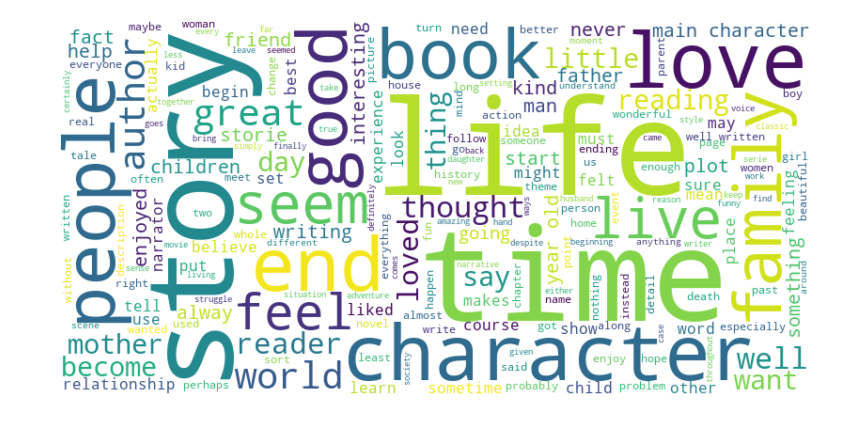

In [56]:
# wordcloud for general fiction book reviews
_ = generate_wordcloud('fiction', fiction_wordcloud_path)

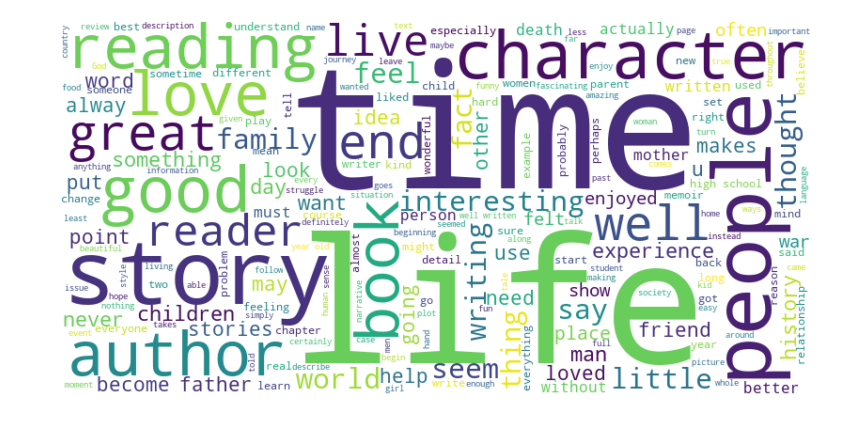

In [57]:
# wordcloud for non-fiction book reviews
_ = generate_wordcloud('non-fiction', nonfiction_wordcloud_path)

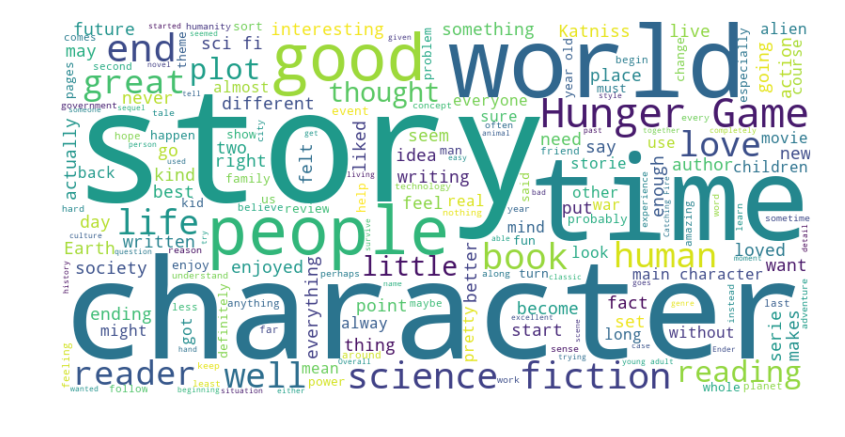

In [58]:
# wordcloud for science-fiction book reviews
_ = generate_wordcloud('science-fiction', scifi_wordcloud_path)

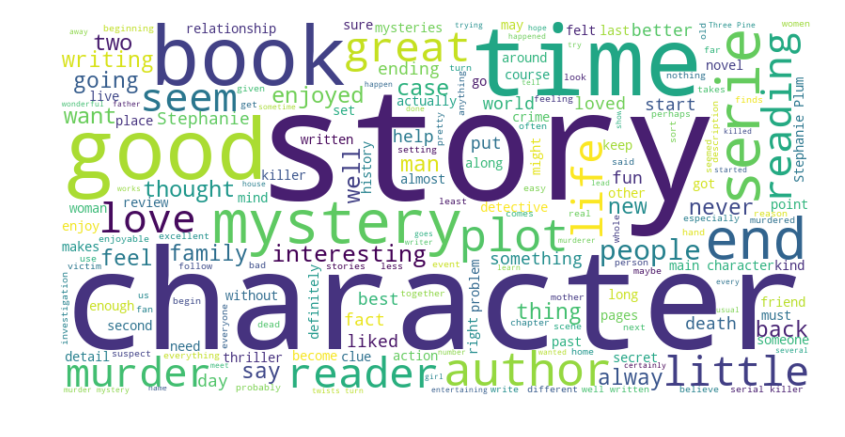

In [59]:
# wordcloud for mystery book reviews
_ = generate_wordcloud('mystery', mystery_wordcloud_path)

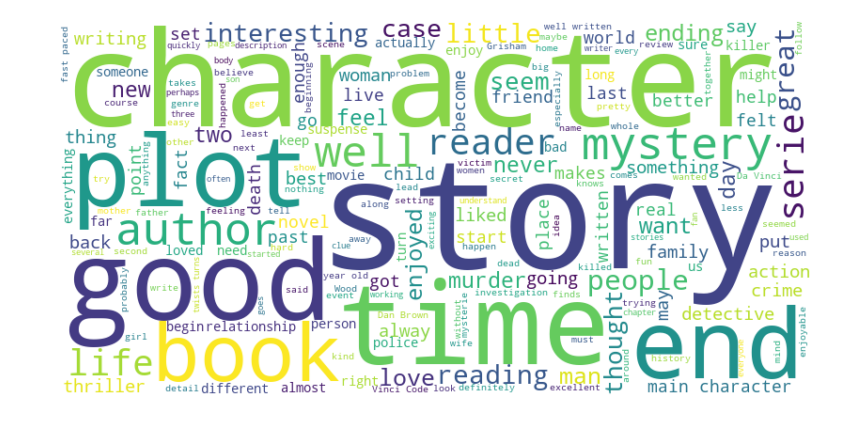

In [60]:
# wordcloud for thriller book reviews
_ = generate_wordcloud('thriller', thriller_wordcloud_path)

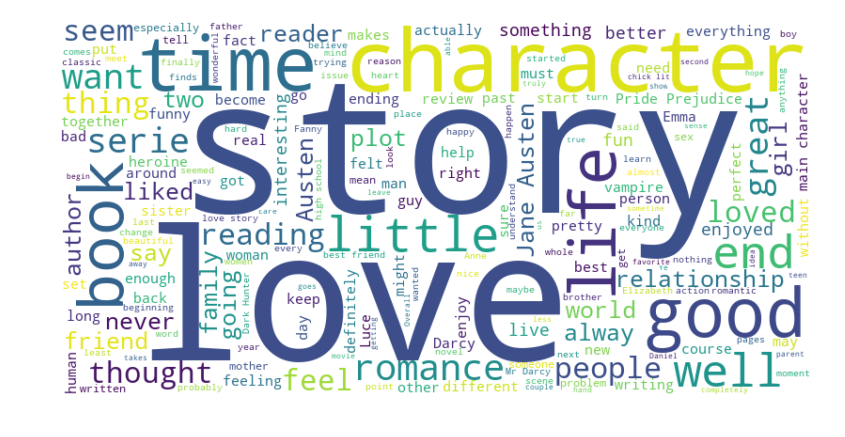

In [61]:
# wordcloud for romance book reviews
_ = generate_wordcloud('romance', romance_wordcloud_path )

<font color=navy>
    The wordclouds show that even though some words are found across book reviews of different genres (e.g. "story", "character"), there are some differences. This is encouraging and I am curious to see if some of the topics my model will identify can be linked to book genres. Next, I will plot word counts on bar plots to get a more quantitative picture of how book review content changes with book genres.
    </font>

In [62]:
fantasy_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'fantasy']
fiction_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'fiction']
nonfiction_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'non-fiction']
scifi_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'science-fiction']
mystery_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'mystery']
thriller_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'thriller']
romance_reviews = book_info_reviews_genres.reviews[book_info_reviews_genres.book_genres == 'romance']

In [63]:
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

In [64]:
def generate_word_counts_fig(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
  
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    _ = ax.set(ylabel = 'Count')

In [65]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [66]:
def lemmatize_text(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [67]:
def plot_word_frequency(reviews):
    reviews = reviews.str.replace("n\'t", " not")   # replace "n't" with " not"
    reviews = reviews.str.replace("[^a-zA-Z#]", " ") # remove unwanted characters, numbers and symbols
    reviews = reviews.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2])) # remove short words (length < 3)
    reviews = [remove_stopwords(r.split()) for r in reviews] # remove stopwords from the text
    reviews = [r.lower() for r in reviews]    # make entire text lowercase
    
    tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
    lemma_reviews = lemmatize_text(tokenized_reviews)
    clean_reviews = []
    for i in range(len(lemma_reviews)):
        clean_reviews.append(' '.join(lemma_reviews[i]))

    clean_series = pd.Series(clean_reviews)
    figure = generate_word_counts_fig(clean_series)
    
    return figure

<font color=darkgreen>
    <b><u> Plot of the word counts for fantasy reviews</b></u>
    </font>

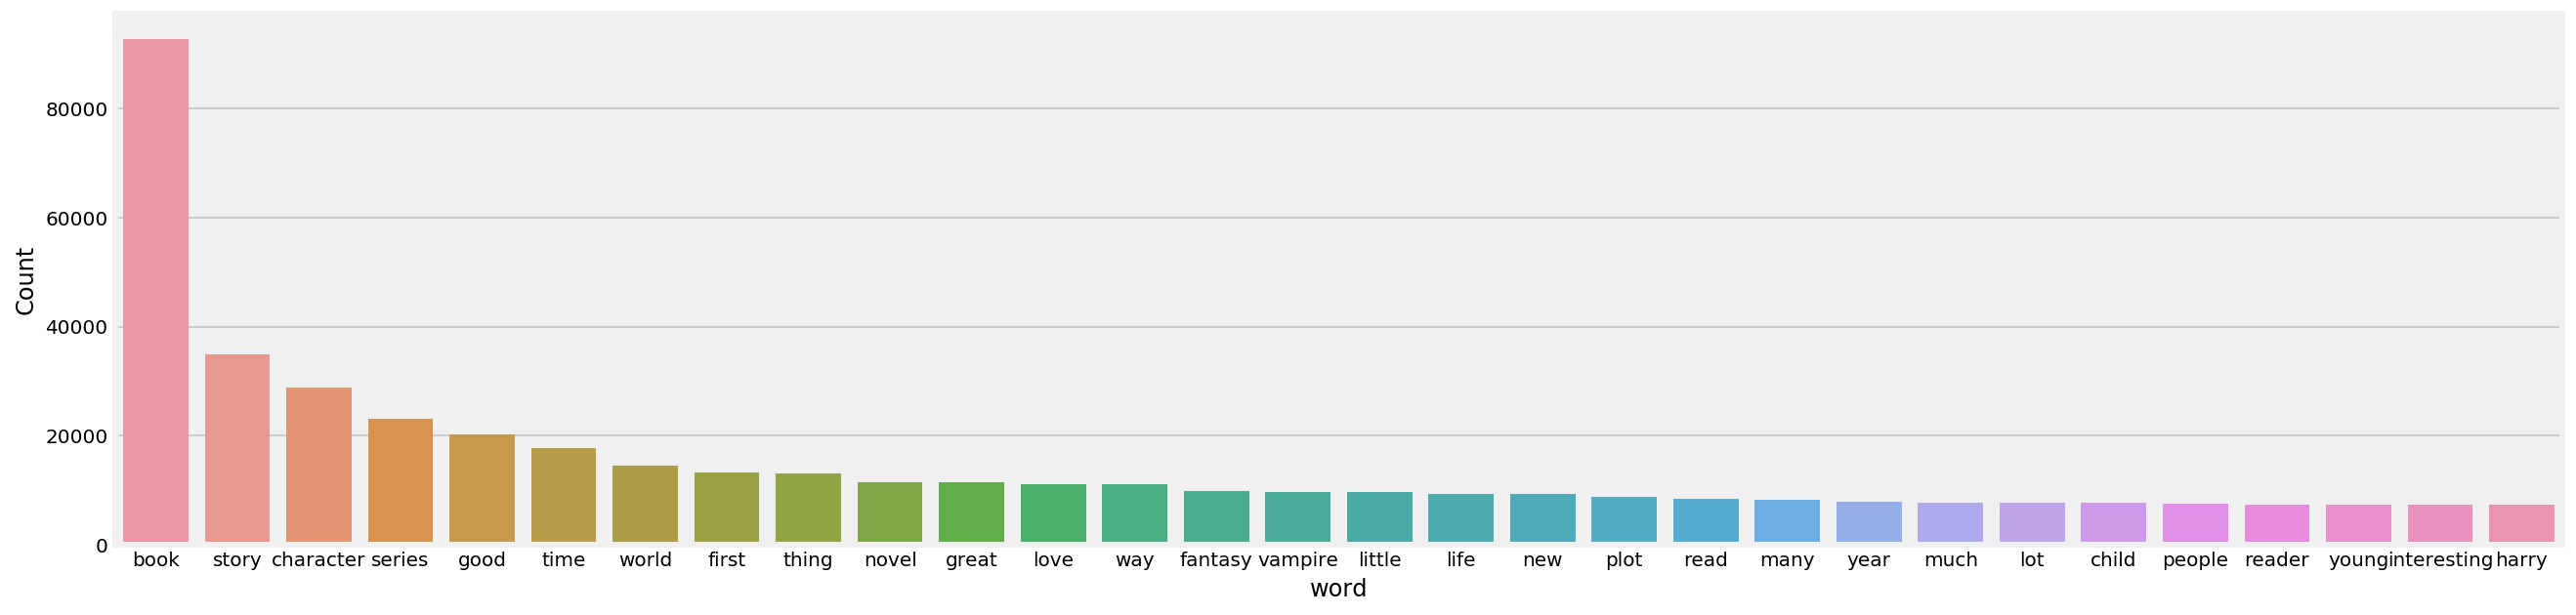

In [68]:
plot_word_frequency(fantasy_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for fiction reviews</b></u>
    </font>

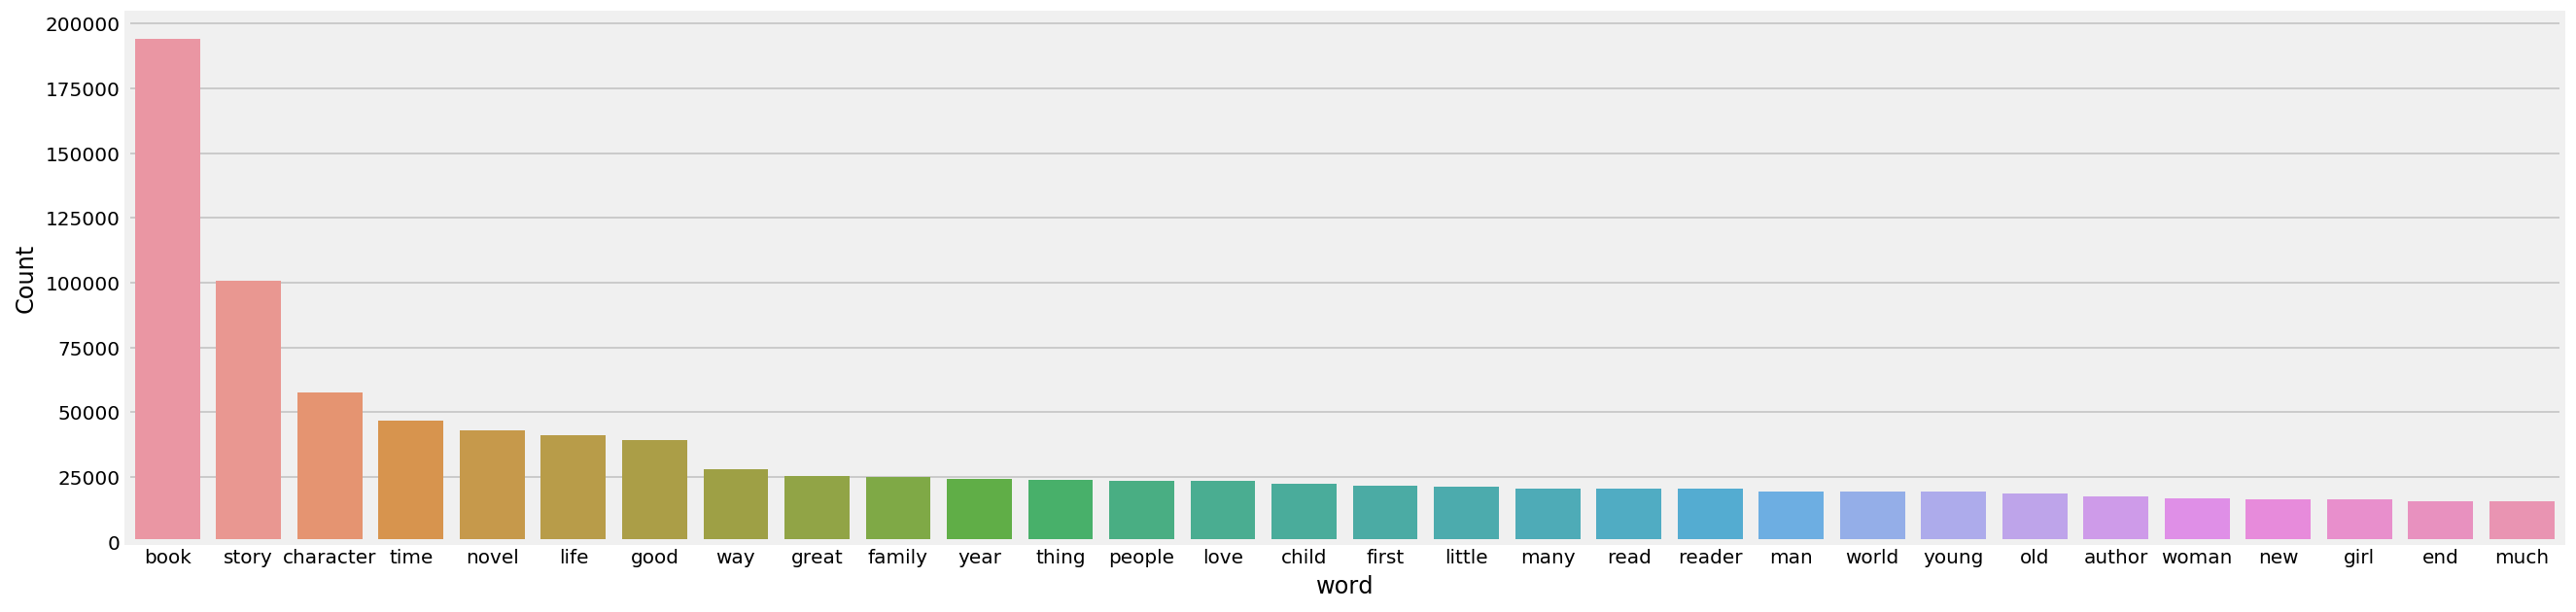

In [69]:
plot_word_frequency(fiction_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for non-fiction reviews</b></u>
    </font>

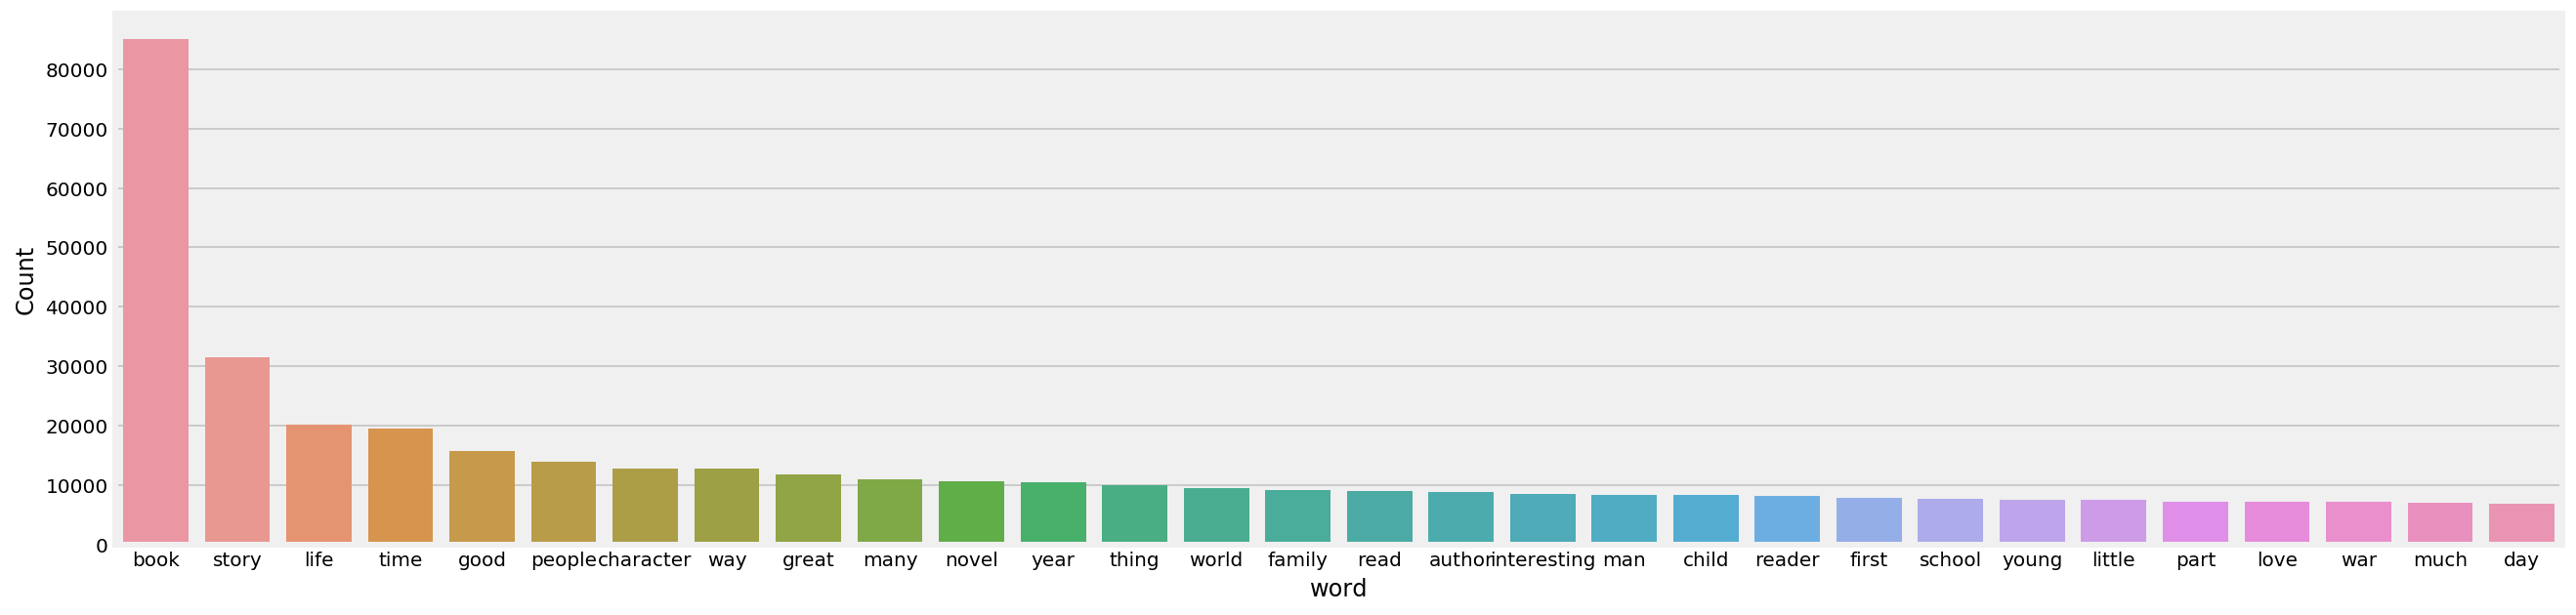

In [70]:
plot_word_frequency(nonfiction_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for science-fiction reviews</b></u>
    </font>

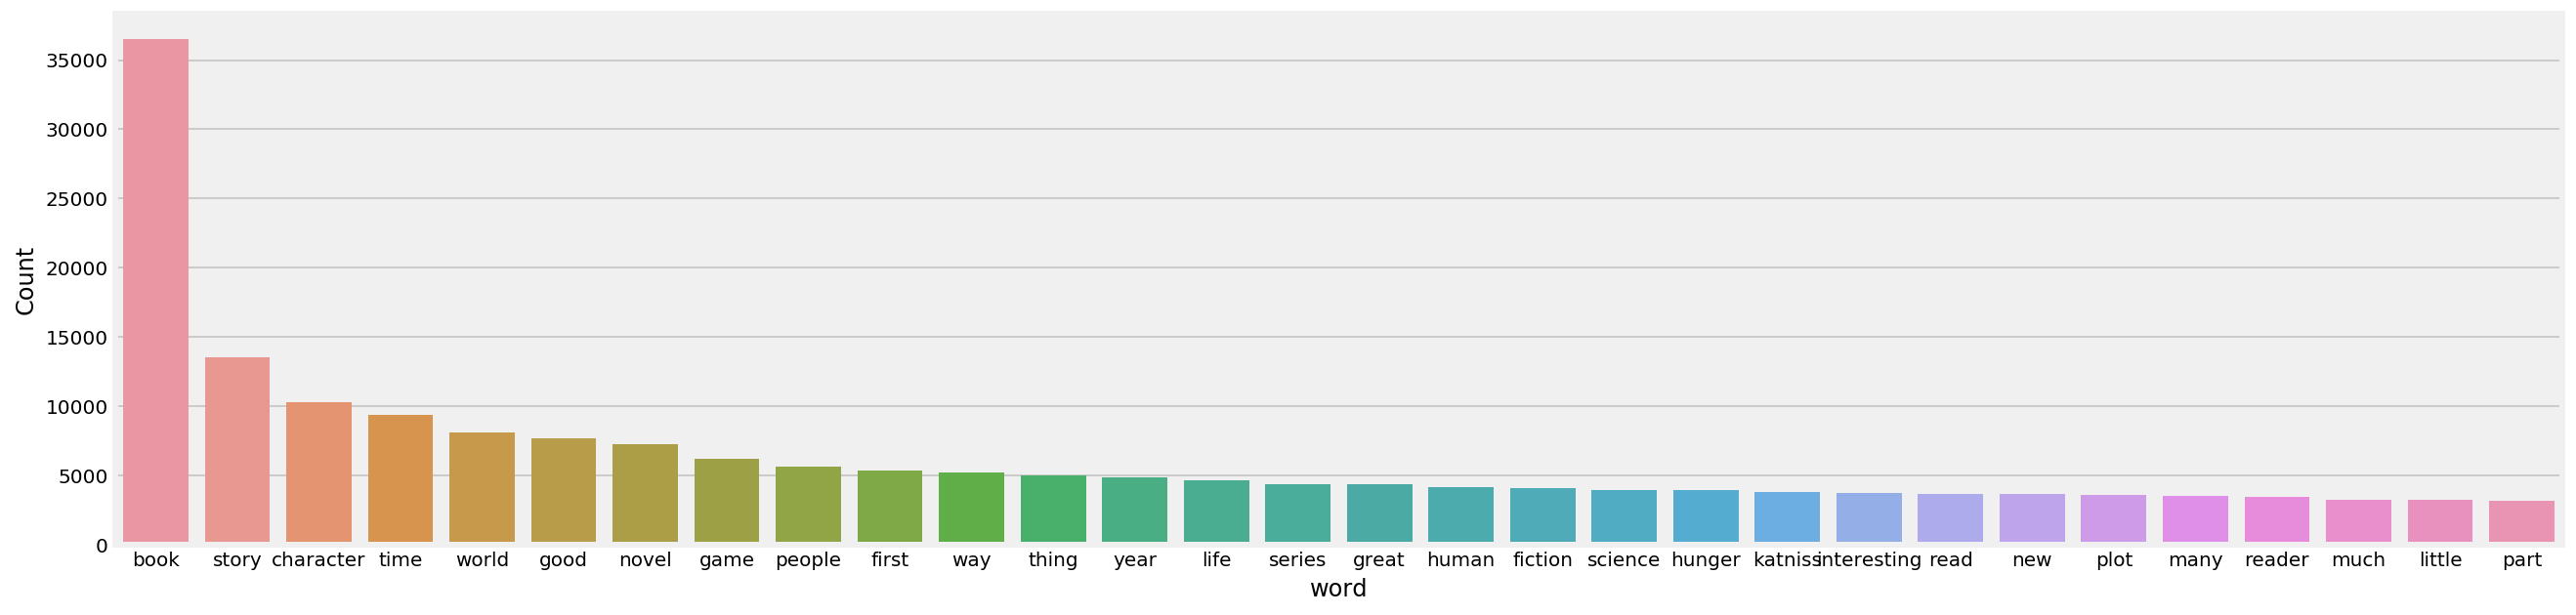

In [71]:
plot_word_frequency(scifi_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for mystery reviews</b></u>
    </font>

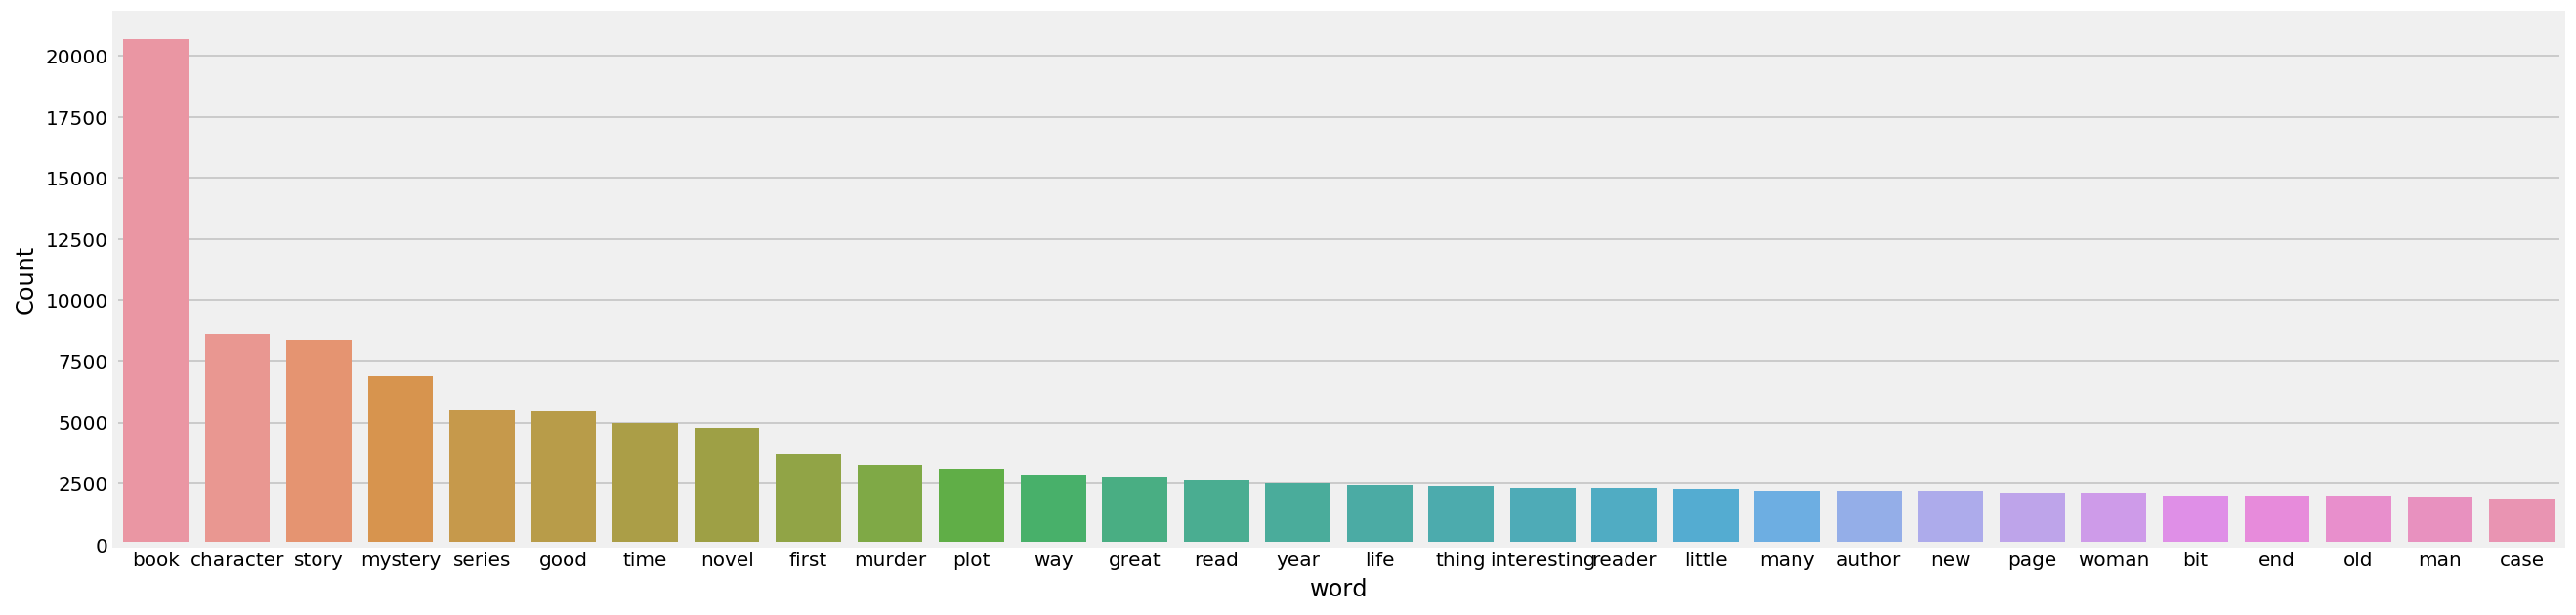

In [72]:
plot_word_frequency(mystery_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for thriller reviews</b></u>
    </font>

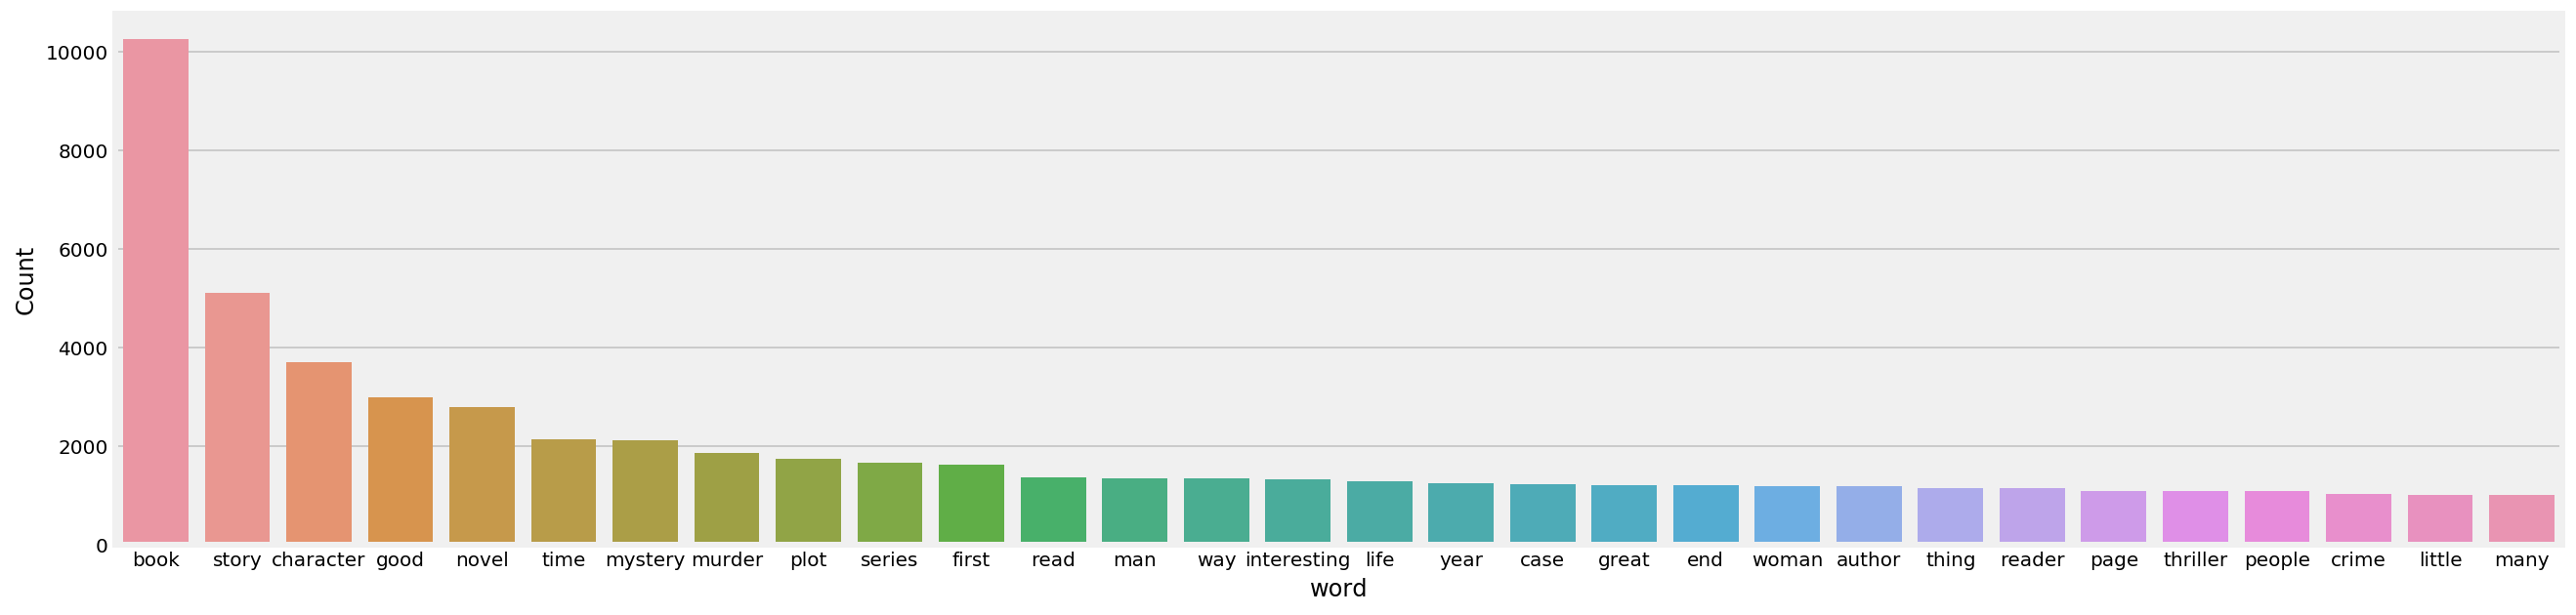

In [73]:
plot_word_frequency(thriller_reviews)

<font color=darkgreen>
    <b><u> Plot of the word counts for romance reviews</b></u>
    </font>

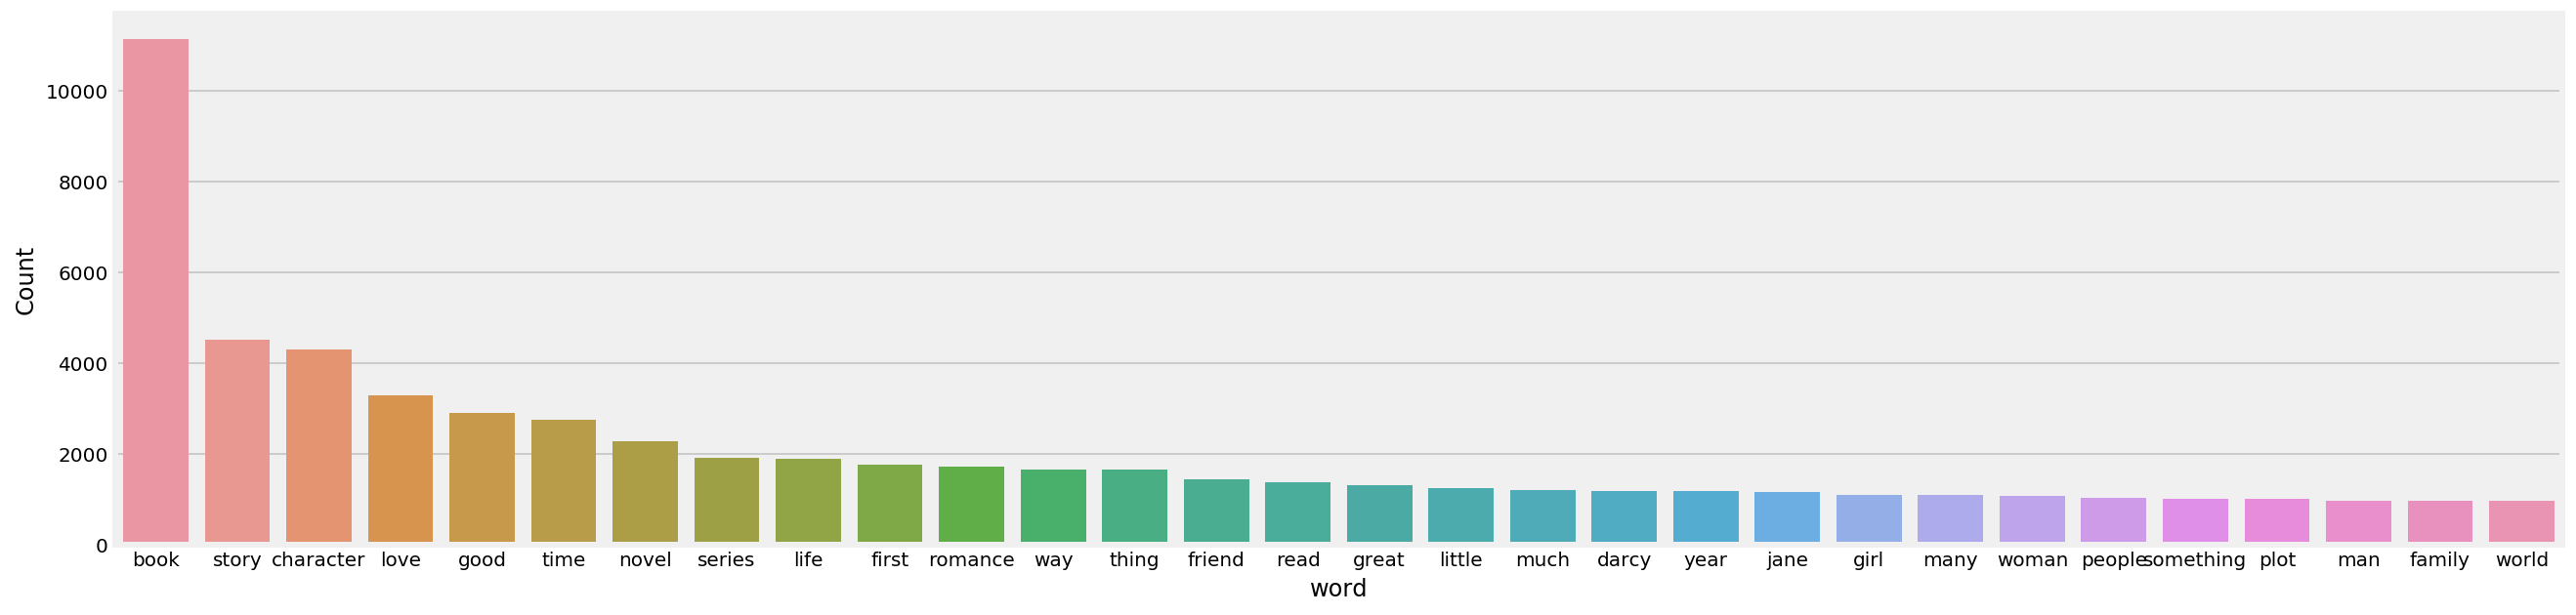

In [74]:
plot_word_frequency(romance_reviews)

<font color=navy>
    As with the wordclouds, the bar plots reveal some common words across all genres, including "book", "story", "character", "time" and "good". They also show that some words are more common in some genres than others (e.g. "mystery" or "plot" for thriller and mystery books), which suggests that a topic model of all reviews may yield distinct topics for the different genres. After assessing these plots, and taking into account that some frequent words are shared across all genres, I think that having one topic model with all reviews would be more effective than having a topic model for each genre.
    </font>